# Predictive Modeling of Heart Disease Risk: Assessing the Role of Aerobic Fitness and Age #

## Introduction ##
#### Background information: ####

The heart’s ability to control its rate with physical demands, which is a reflection of its aerobic capacity, plays a crucial role in cardiovascular health. Maximum heart rate is defined as the upper limit of what an individual's cardiovascular system can handle during physical activity, thus a higher maximum heart rate is typically an indication of a stronger cardiovascular system. So, we can use an individual's maximum heart rate as a measure to determine their aerobic fitness capacity (UC Davis Health, 2013). An increased aerobic fitness capacity has been proven to be inversely related to the risk of heart attacks and cardiovascular disease (LeWine, 2023). A higher maximum heart rate, therefore, not only reflects physical fitness but also correlates with broader health outcomes, including heart disease prevention.
#### Our Question: ####
Can we predict the likelihood of a patient developing heart disease based on their maximum heart rate and age?
#### The Dataset: ####
We will be using the Heart Disease dataset from the UC Irvine Machine Learning Repository. The dataset includes various attributes related to heart disease diganosis. Each row in the dataset represents a patient and it contains the following variables as columns (in order): age, sex, chest pain type (4 types), resting blood pressure (mm Hg), serum cholesterol (mg/dl), fasting blood sugar, resting ECG results (3 types), max heart rate, exercise induced angina (1 = present, 0 = absent), ST depression, slope of peak exercise ST segment (3 types), number of major vessels coloured by fluoroscopy (0-3), thalassemia, and presence of heart disease (0 = no, 1-4 = yes).

## Preliminary exploratory data analysis ##

In [1]:
# trestbps: resting blood pressure (mm Hg), chol: total amount of cholesterol in the body (mg/dl)
# num: presence of heart disease in a patient (presence = 1,2,3,4), (absence = 0)

library(tidyverse)
library(repr)
library(tidymodels)
# clean and wrangle data into a tidy data format
url <- "https://raw.githubusercontent.com/Isabella72/Group_project/main/processed.cleveland.data"
heart_data <- read_csv(url, col_names = FALSE) |>
        rename(age = X1, maxhr = X8, disease = X14) |>
        select(age, maxhr, disease) |>
        mutate(disease = as_factor(disease)) |>
        mutate(disease = fct_recode(disease, "Present" = "1", "Present" = "2", "Present" = "3", "Present" = "4", "Absent" = "0"))


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
slice_head(heart_data, n = 3)

age,maxhr,disease
<dbl>,<dbl>,<fct>
63,150,Absent
67,108,Present
67,129,Present


Table 1: A preview of the first three rows of the heart disease data set

In [3]:

num_obs <- nrow(heart_data)
heart_data |>
    group_by(disease) |>
    summarize(count = n(), percentage = n()/ num_obs * 100)

disease,count,percentage
<fct>,<int>,<dbl>
Absent,164,54.12541
Present,139,45.87459


Table 1.1: The percentage of observations with heart disease versus the percentage of healthy individuals

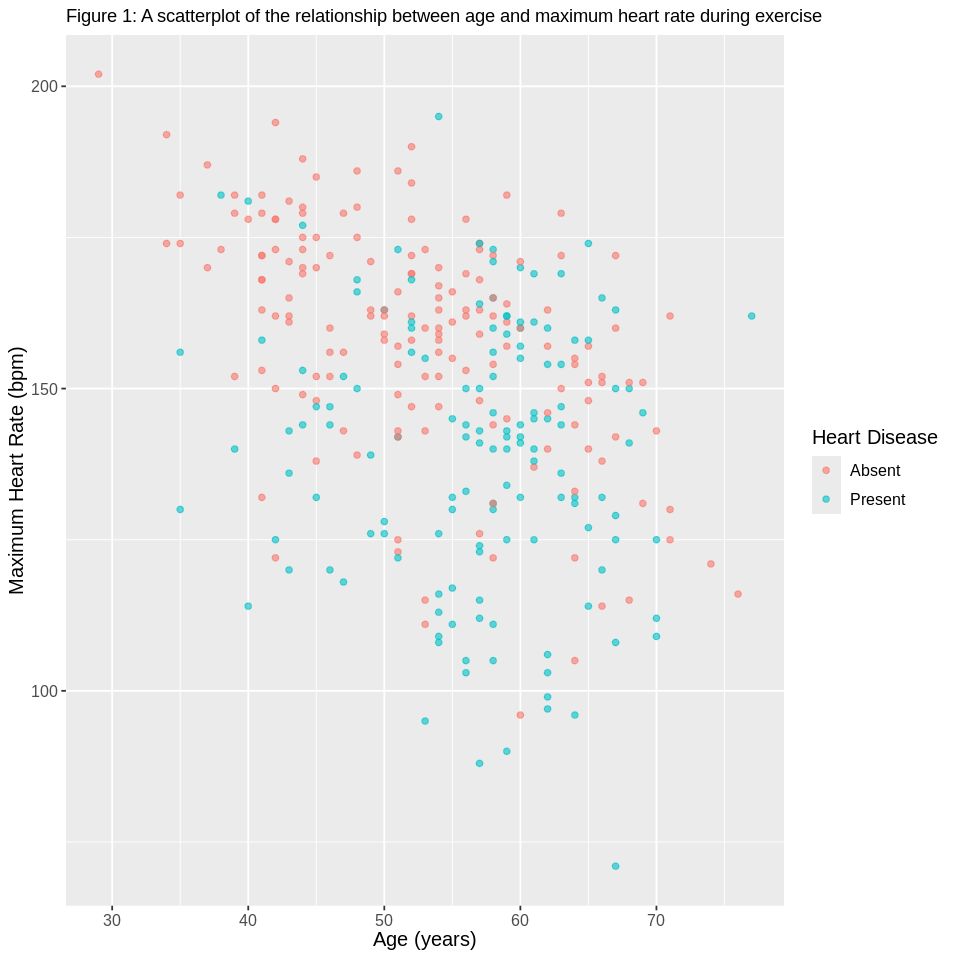

In [4]:
options(repr.plot.width = 8, repr.plot.height = 8)
heart_plot <- heart_data |>
  ggplot(aes(x = age, y = maxhr, color = disease)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age (years)",
       y = "Maximum Heart Rate (bpm)",
       color = "Heart Disease") +
    theme(text = element_text(size = 12)) +
    theme(plot.title = element_text(size = 11)) +
    ggtitle("Figure 1: A scatterplot of the relationship between age and maximum heart rate during exercise")
heart_plot

In [28]:
set.seed(2323)
# create the 25/75 split of the data into training and testing
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# preprocess the data
heart_recipe <- recipe(disease ~., data = heart_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())

# tuning the classifier
heart_vfold <- vfold_cv(heart_train, v = 10, strata = disease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
vfold_metrics <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec) |>
                  tune_grid(resamples = heart_vfold, grid = k_vals) |>
                  collect_metrics() |>
                  filter(.metric == "accuracy") |>
                  arrange(desc(mean))
k <- vfold_metrics |>
    slice_max(n = 1, order_by = mean) |>
    select(neighbors) |>
    pull()

# predict the labels in our test set
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
        set_engine("kknn") |>
        set_mode("classification")
best_fit <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(best_spec) |>
        fit(data = heart_train)
disease_predictions <- predict(best_fit, heart_test) |>
        bind_cols(heart_test)

# evaluate performance
heart_metrics <- disease_predictions |>
  metrics(truth = disease, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
precision <- disease_predictions |>
        precision(truth = disease, estimate = .pred_class)
heart_metrics <- heart_metrics |>
        bind_rows(precision)

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
precision,binary,0.7560976


Table 1.3: The prediction accuracy and precision of our model on the test data

In [17]:
conf_mat <- disease_predictions |>
  conf_mat(truth = disease, estimate = .pred_class)
conf_mat

          Truth
Prediction Absent Present
   Absent      31      10
   Present     10      25

Table 1.4: The confusion matrix for our model making predictions on the test set

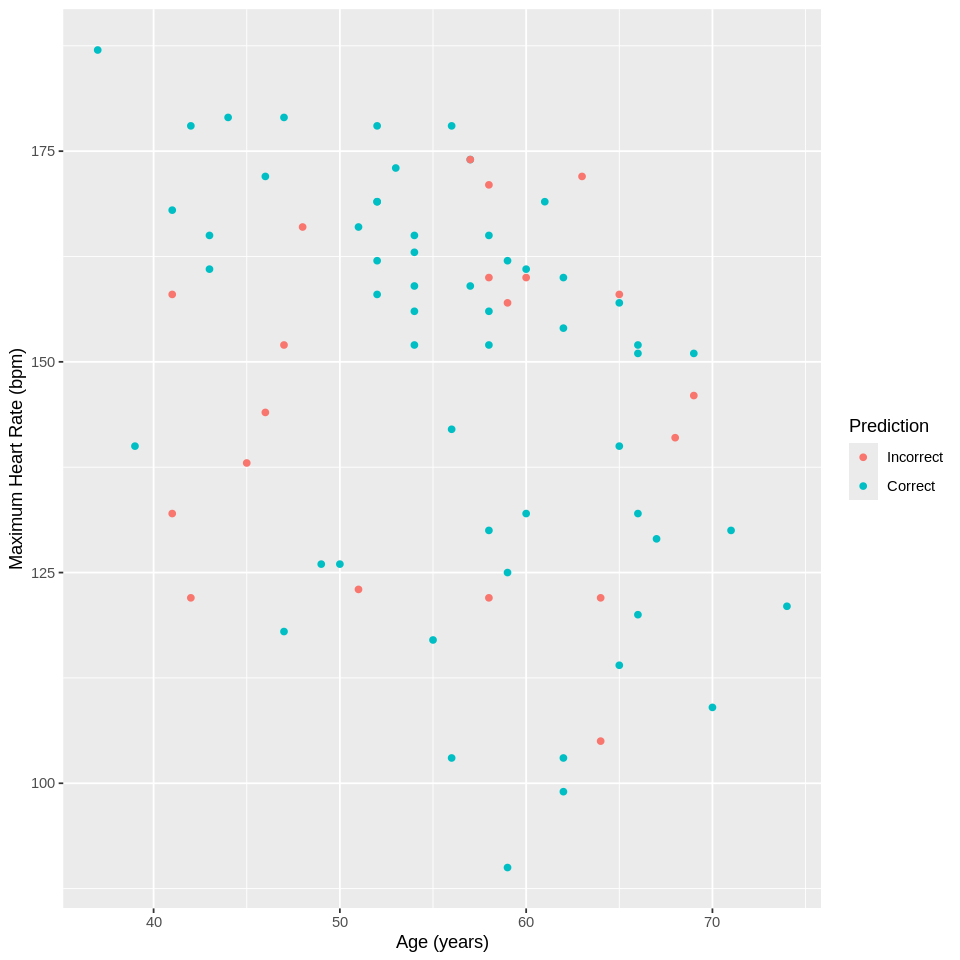

In [18]:

conf_vals <- disease_predictions |>
        mutate(conf = .pred_class == disease) |>
        mutate(conf = as_factor(conf)) |>
        mutate(conf = fct_recode(conf, "Correct" = "TRUE", "Incorrect" = "FALSE"))
conf_plot <- conf_vals |>
        ggplot(aes(x = age, y = maxhr, color = conf)) +
        geom_point() +
        labs(x = "Age (years)", y = "Maximum Heart Rate (bpm)", color = "Prediction")
conf_plot

Figure 1.1: A plot of all predictions done on test data coloured based on whether the predition is correct or incorrect

## Methods & Results ##
1. Created the train/test split:
    - Set a seed so that our code is reproducable
    - Used the initial_split function to create a 25/75 split
    - Assigned testing data to heart_test and training data to heart_train
3. Preprocess the data:
    - Constructed a recipe with the predictor varibles age and maxhr.
    - Prepared the recipe to center and scale our predictors using the training data

4. Train the classifier:
   - Set up our model to use 10-fold cross validation using the v_fold_cv function
   - Created our model specification and set it up for tuning using the tune function
   - We created the k_vals data frame with the neighbours variable containing values from 1 to 50 using the seq function.
   - We passed k_vals into the grid argument of tune_grid to get the model's metrics for every value of k up to and including 50.
   - We wanted the k-value that gave the highest accuracy, so we filtered .metric for rows that represented accuracy and arranged our data so the highest value in the mean column was in the first row
   - We used the slice_max and pull functions to obtain the best k value and put that directly into our new model specification
5. Predict labels in our test set:
   - Now that we had our best model, we used it to make predictions on our test data by creating a workflow and using the predict function
6. Evaluate performance
   - We evaluated the accuracy of these predictions by binding the test data set to our predictions, so that we could use the metrics function with the true value of the disease column being passed to truth.
   - Filtered for the accuracy metric and found our model has an accuracy of around 73.7%
   - We used the precision function and found our model has a precision of around 75.6%
   - Created a confusion matrix to get a better idea of the type of mistakes made by our predictor
   - Generated a visulization that colours observations from our test set based on whether or not they were predicted correctly, it helps us notice that there is a random scattering of incorrect predictions, but there are many more correct than incorrect.


## Discussion ##
(!!!) Such
findings can inform people about the importance of managing these risk factors to
reduce the development of heart disease. The results of this analysis may lead to further
research into the mechanisms that link blood pressure and cholesterol levels to heart
disease and to the identification of new preventive strategies. Examples might include
exploring the role of genetic factors, lifestyle, and age in modifying the relationship
between blood pressure, cholesterol, and heart disease risk.

Future investigations could explore potential interactions between resting blood
pressure, serum cholesterol, and other variables not included in this analysis, such as
age, gender, or lifestyle factors.

$\hspace{250 pt}$ $\textbf{References}$ \
\
LeWine, H. E. (2023, June 13). What your heart rate is telling you. Harvard Health. \
www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you#:~:text=Your%20maximum%20heart%20rate%20plays,of%20heart%20attack%20and%20death. 
\
\
UC Davis Health. (2013). Vo2max and oxygen consumption: UC Davis Sports Medicine. VO2max and Oxygen Consumption | UC Davis Sports Medicine. $\hspace{25 pt}$ https://health.ucdavis.edu/sports-medicine/resources/vo2description 
